In [1204]:
import scraper_utils as su
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV,RidgeCV
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import seaborn as sns
sns.set_theme()
sns.set_context('talk')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data in

Load in from csv, add columns for other possible objective functions, filter out old games, then split into training and test data.

In [1205]:
df = pd.read_csv('data/games_allcats.csv', index_col = 'Name')
df.rename(columns={'average':'avg_rating'}, inplace = True)
df['log_owned'] = np.log(df['numowned'])
df['log_plays'] = np.log(df['numplays'])
df['avg_rating^2'] = df['avg_rating']**2
df['log_rating'] = np.log(df['avg_rating'])
df['sqrt_minplaytime'] = np.sqrt(df['minplaytime'])
df['sqrt_maxplaytime'] = np.sqrt(df['maxplaytime'])
df['sqrt_price'] = np.sqrt(df['median_price'])
df['age'] = 2021-df['yearpublished']
df['yearly_plays']=df['numplays']/df['age']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, Gloomhaven to Santa Maria Infante: On the Road to Rome 1944
Columns: 107 entries, id to yearly_plays
dtypes: float64(24), int64(83)
memory usage: 5.3+ MB


In [1206]:
df.fillna(0,inplace=True)

In [1207]:
df=df[df['num_listings']>0]
df=df[df['yearpublished']>=2010]
df=df[df['yearpublished']<=2019]
df=df[df['minage']>0]

In [1208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2607 entries, Gloomhaven to Let's Take a Hike
Columns: 107 entries, id to yearly_plays
dtypes: float64(24), int64(83)
memory usage: 2.1+ MB


In [1209]:
train_df, test_df = train_test_split(df, test_size=.2)

In [1210]:
with open("data/category_dict.pkl", 'rb') as picklefile: 
    category_dict = pickle.load(picklefile)
    

## Define sets of columns 

In [1211]:
#Game properties, ie things that the game maker can control
game_properties = ['avgweight', 'minplayers', 'maxplayers',
                   'minplaytime', 'maxplaytime', 'minage', 'median_price']
#game_properties = ['avgweight', 'minplayers', 'maxplayers',
#                   'minplaytime', 'minage', 'median_price']


game_properties_sqrt = ['avgweight','minplayers','maxplayers', 'sqrt_minplaytime','sqrt_maxplaytime', 'minage', 'sqrt_price']
#Game properties, no price
game_properties_np = ['avgweight', 'minplayers', 'maxplayers',
                     'minplaytime', 'maxplaytime', 'minage']

#Types
type_cols = ['customizable', 'family', 'strategy', 'thematic']

In [1212]:
selected_categories = top10_cats + ['Adventure', 'Party Game', 'Miniatures', 'City Building',
                                    'Exploration','Bluffing','Animals','Fighting']

In [1213]:
#Lists of top 10/20/30 categories
top10_cats = list(category_dict.values())[:10]
top20_cats = list(category_dict.values())[:20]
top30_cats = list(category_dict.values())[:30]

#Combined numeric, type, and category columns - what mostly gets used for xcols
x_cols_10 = game_properties + type_cols + top10_cats
x_cols_20 = game_properties + type_cols + top20_cats
x_cols_30 = game_properties + type_cols + top30_cats
x_cols    = game_properties + type_cols + selected_categories

x_cols_sqrt = game_properties + type_cols + selected_categories

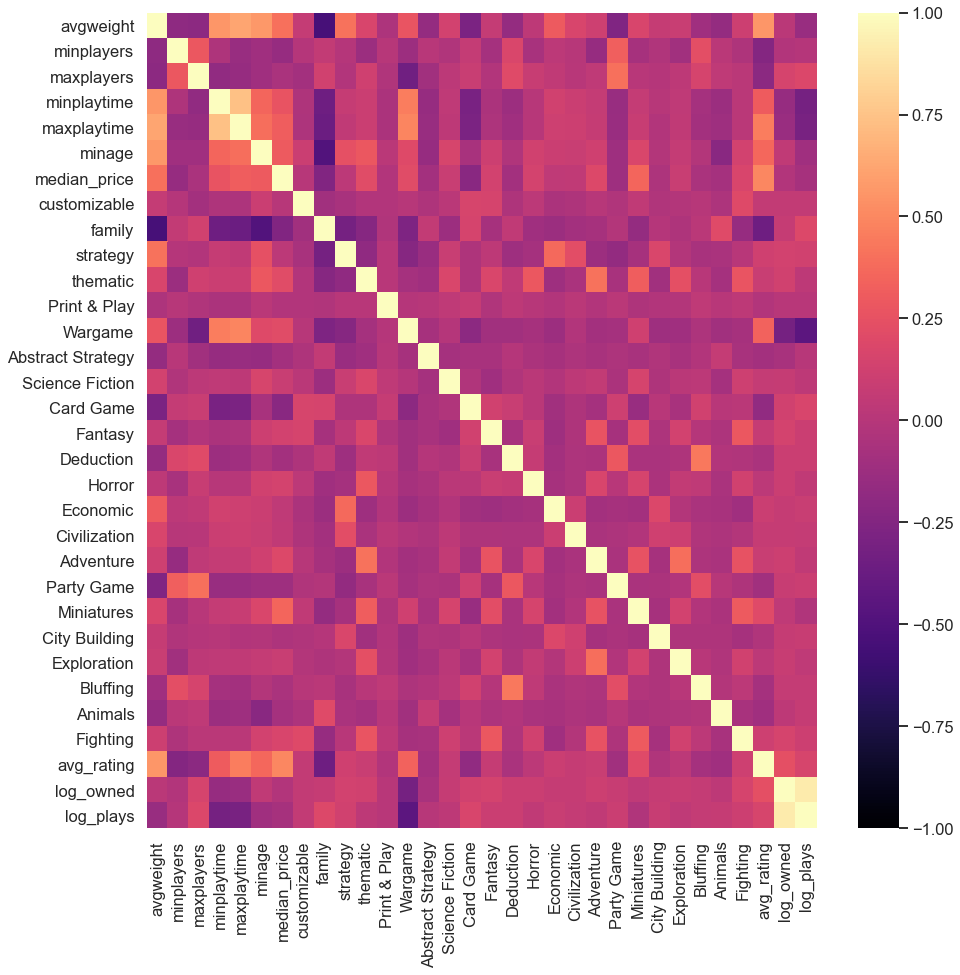

In [1214]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df[x_cols + ['avg_rating', 'log_owned', 'log_plays']].corr(),  cmap="magma", vmin=-1, vmax=1, ax=ax);

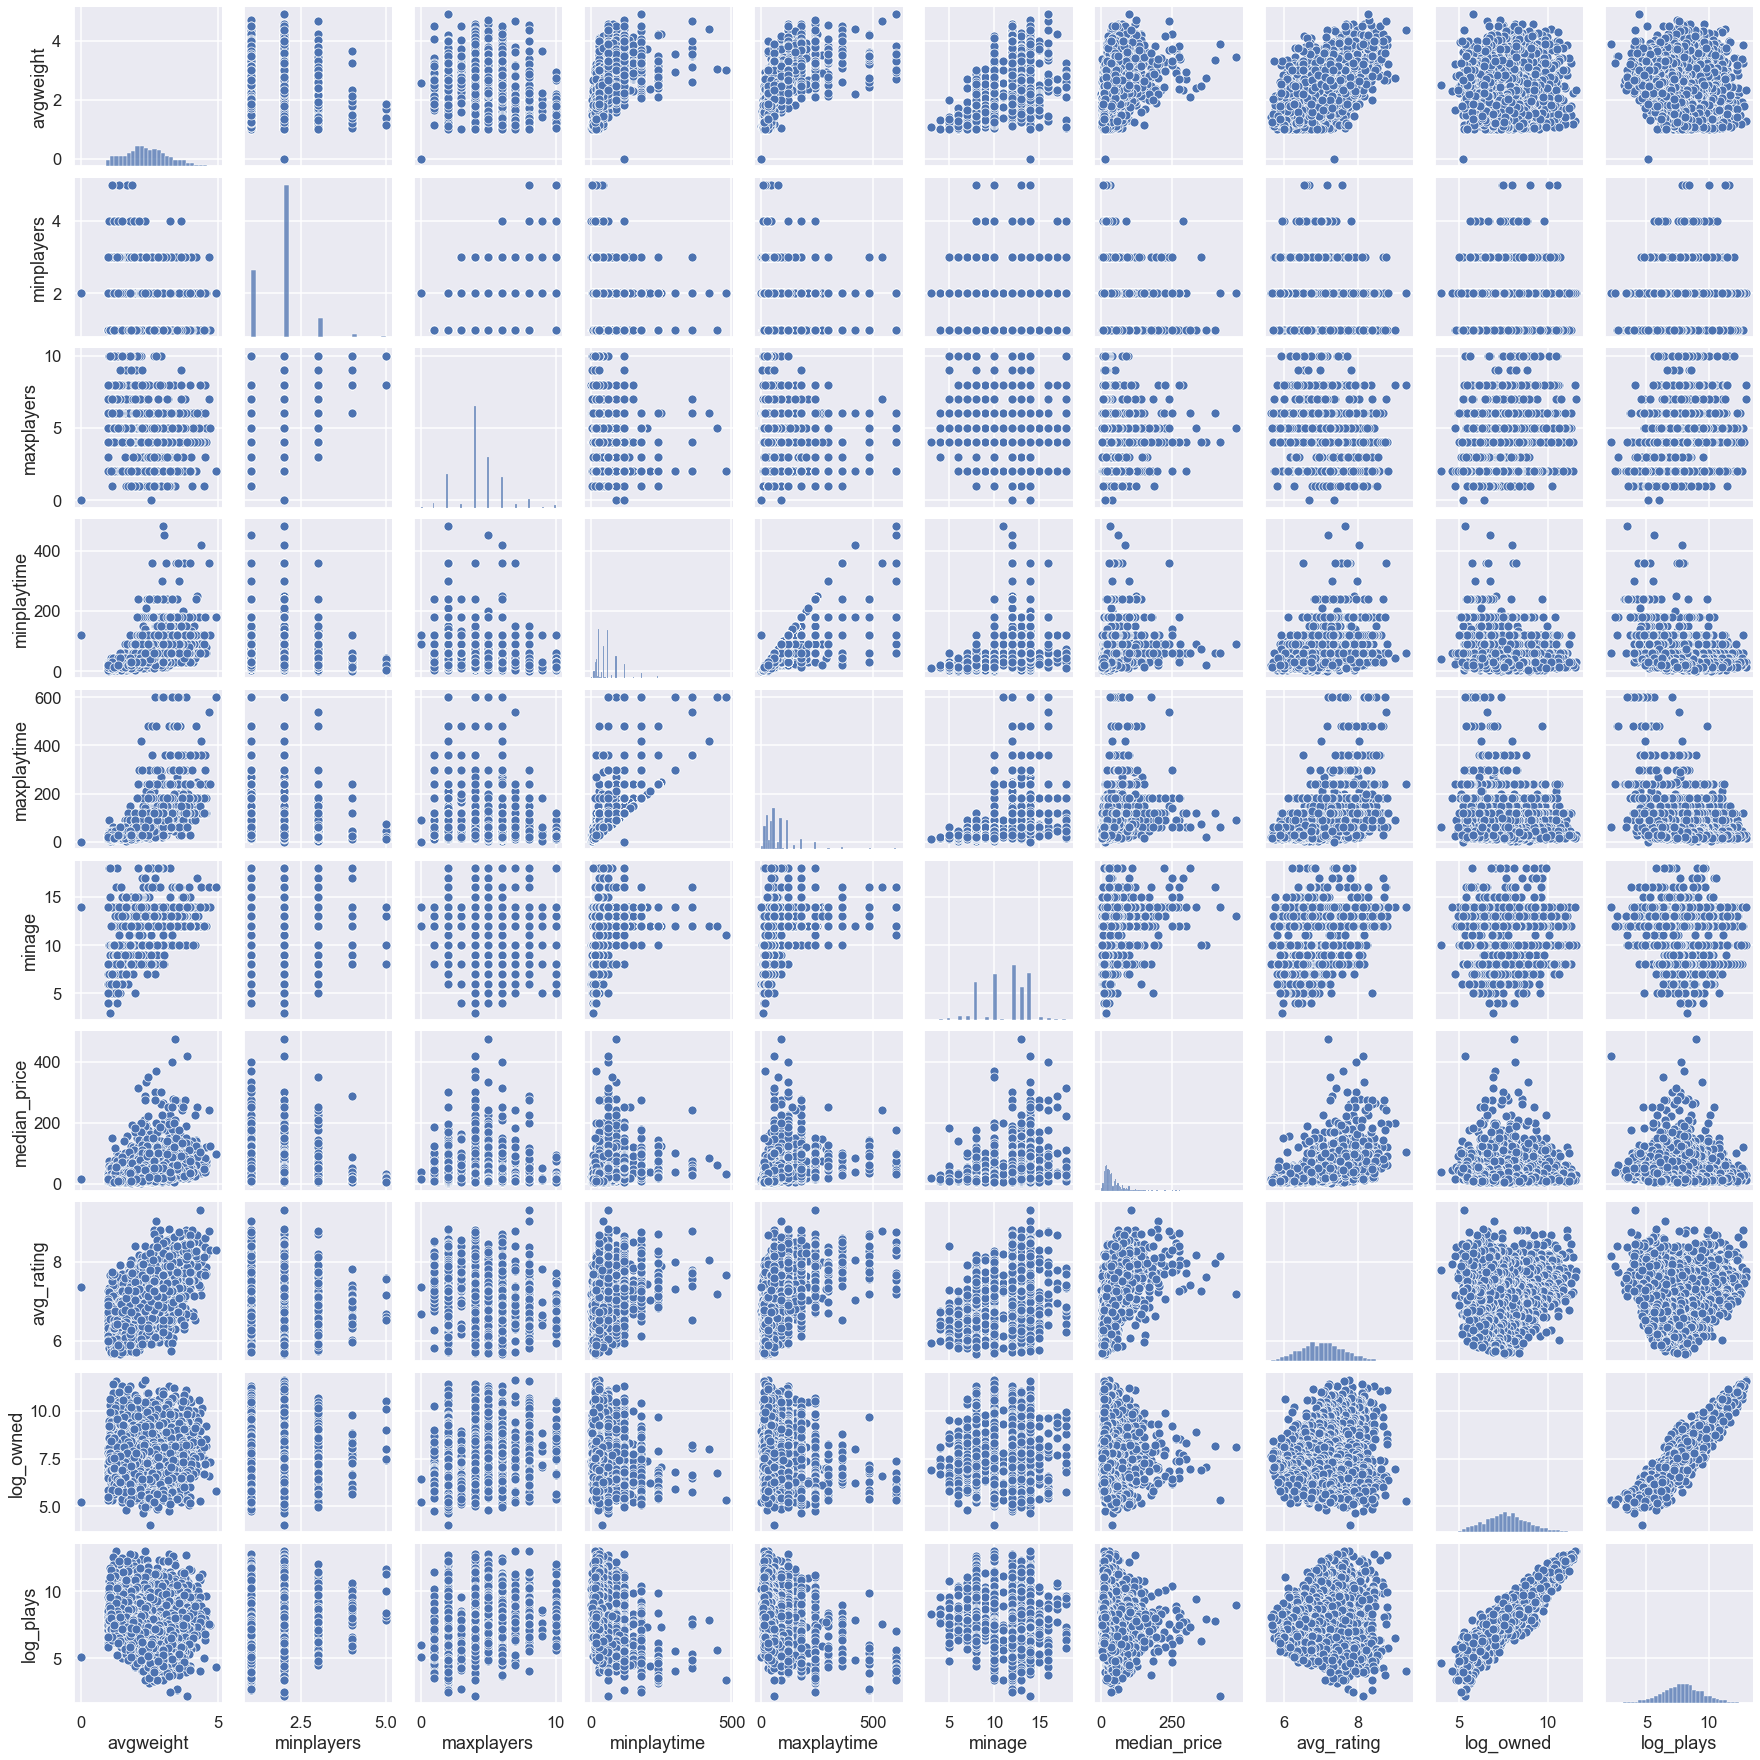

In [1215]:
sns.pairplot(df[game_properties + ['avg_rating', 'log_owned', 'log_plays']])

## Functions for quickly testing models

In [1216]:
def lr_cv(df, xcols, ycol, fitter, fit_params = {}, transformer = None,
          scale = False, show_results = True, xcols_name = ''):
    """
    Takes in df, names of columns to use as x and y, and finds cross validation score. Use for testing out model
    and parameters. Use fit_plot_train to do only one and graph real vs predicted /residual
    """
    X = df[xcols].copy()
    y = df[ycol].copy()
    
    if transformer:
        X = transformer.fit_transform(X)
    if scale:
        scaler = StandardScaler()
        X=scaler.fit_transform(X)
    fitter.set_params(**fit_params)
    cv_results = cross_validate(fitter, X, y, scoring = ('r2', 'neg_mean_absolute_error'),
                                return_train_score = True)
    test_r2 = cv_results['test_r2']
    test_MAE = -1*cv_results['test_neg_mean_absolute_error']
    train_r2 = cv_results['train_r2']

    if show_results:
        print('Objective:', ycol)
        print(f'Features: ', xcols_name)
        print('Mean train r2: {:.3f}'.format(np.mean(train_r2)))
        print('Mean test r2:  {:.3f}'.format(np.mean(test_r2)))
        #print('Mean test MAE: {:.3f}'.format( np.mean(test_MAE)))
        print()
    return cv_results

In [1217]:
def fit_plot_train(train_df, xcols, ycol, objective_name, fitter, 
                   transformer= None, scale=False, show_graphs = True):
    '''
    For use while finding optimal model. Split training data further into training/validation data, fit it with
    fitter with parameters fit_params, then give statistics. Also plots the real vs predicted objective and residuals.
    
    '''
    X = train_df[xcols].copy()
    y = train_df[ycol].copy()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
    if transformer:
        transformer.fit(X_train)
        X_train = transformer.transform(X_train)
        X_test = transformer.transform(X_test)
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
    
    fitter.fit(X_train, y_train)
    y_pred = fitter.predict(X_test)
    r2 = fitter.score(X_test, y_test)
    MAE = mean_absolute_error(y_test, y_pred)
    
    print('R^2: {:.3f}'.format(r2))
    print('MAE: {:.3f}'.format(MAE))
    
    plt.figure(figsize=(9,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Real '+objective_name)
    plt.ylabel('Predicted '+objective_name)
    plt.title('Real vs predicted ' + objective_name)
    yx_line = np.linspace(np.min(y_test),np.max(y_test),1000)
    plt.plot(yx_line,yx_line,color='black')
    plt.show()
    
    plt.figure(figsize=(9,6))
    res = (np.array(y_pred)-np.array(y_test))
    sns.scatterplot(x=y_pred, y=res)
    plt.xlabel('Predicted '+objective_name)
    plt.ylabel('Residual')
    plt.title('Residual ' + objective_name)
    plt.hlines(0,np.min(y_pred),np.max(y_pred),colors='black')
    plt.show()

    


## Testing various parameters

### Objective function

In [1218]:
lr_cv(train_df, x_cols, 'numowned', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'log_owned', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'numplays', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'numplays_month', LinearRegression(), show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'log_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c');


Objective: numowned
Features:  gp+t+c
Mean train r2: 0.082
Mean test r2:  0.038

Objective: log_owned
Features:  gp+t+c
Mean train r2: 0.199
Mean test r2:  0.168

Objective: numplays
Features:  gp+t+c
Mean train r2: 0.059
Mean test r2:  0.016

Objective: numplays_month
Features:  gp+t+c
Mean train r2: 0.044
Mean test r2:  -0.010

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.270
Mean test r2:  0.239

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.471
Mean test r2:  0.447

Objective: log_rating
Features:  gp+t+c
Mean train r2: 0.460
Mean test r2:  0.435



**It appears that Linear regression is best with predicting the average score and the log of the number of players/owners. Overfitting may be a slight issue, will try regularization in a bit**

### Features

#### Dist plots to get an idea of how things are distributed

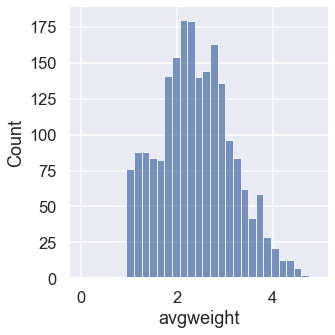

In [1219]:
sns.displot(train_df['avgweight'])
plt.show()

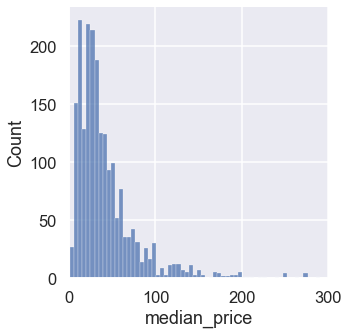

In [1220]:
sns.displot(train_df['median_price'])
plt.xlim((0,300))
plt.show()

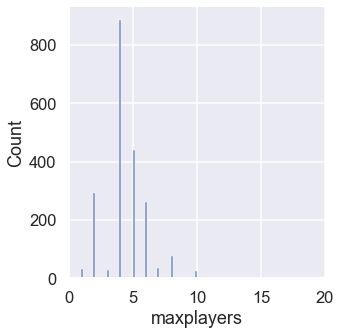

In [1221]:
sns.displot(train_df['maxplayers'])
plt.xlim((0,20))
plt.show()

#### Checking CV scores with differernt xcols

In [1224]:
#logplays objective
lr_cv(train_df, game_properties,    'log_plays', LinearRegression(), show_results=True,xcols_name='gp');
lr_cv(train_df, x_cols,    'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols_10, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c10');
lr_cv(train_df, x_cols_20, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c20');
lr_cv(train_df, x_cols_30, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c30');


Objective: log_plays
Features:  gp
Mean train r2: 0.143
Mean test r2:  0.133

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.270
Mean test r2:  0.239

Objective: log_plays
Features:  gp+t+c10
Mean train r2: 0.255
Mean test r2:  0.231

Objective: log_plays
Features:  gp+t+c20
Mean train r2: 0.266
Mean test r2:  0.229

Objective: log_plays
Features:  gp+t+c30
Mean train r2: 0.277
Mean test r2:  0.228



Not a huge variation between the results, so will go with the game properties + types + selected categories for logplays objective

In [1225]:
lr_cv(train_df, game_properties,    'avg_rating', LinearRegression(), show_results=True,xcols_name='gp');
lr_cv(train_df, x_cols,    'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols_10, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c10');
lr_cv(train_df, x_cols_20, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c20');
lr_cv(train_df, x_cols_30, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c30');

Objective: avg_rating
Features:  gp
Mean train r2: 0.436
Mean test r2:  0.428

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.471
Mean test r2:  0.447

Objective: avg_rating
Features:  gp+t+c10
Mean train r2: 0.461
Mean test r2:  0.444

Objective: avg_rating
Features:  gp+t+c20
Mean train r2: 0.469
Mean test r2:  0.445

Objective: avg_rating
Features:  gp+t+c30
Mean train r2: 0.473
Mean test r2:  0.441



Same story here, will use same feature sets for the two objectives.

### Polynomial transformation

In [1226]:
lr_cv(train_df, x_cols, 'avg_rating', LinearRegression(), transformer = PolynomialFeatures(interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'log_plays', LinearRegression(), transformer = PolynomialFeatures(interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.651
Mean test r2:  -117648539431019208507392.000

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.509
Mean test r2:  -558456179234944212533248.000



Looks like we maybe need some regularization. Looks like it does help on the test data though! For now leaving interaction_only=False. Can take it out later to see if it helps

### Polynomial transformation +  LASSO and Ridge regularization

#### Lasso

In [1227]:
lr_cv(train_df, x_cols, 'log_plays', Lasso(alpha=.1), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=.01), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');



Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.254
Mean test r2:  0.229

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.527
Mean test r2:  0.474



A bit of improvement, will sweep through to find best alpha value

#### Ridge

In [1228]:
lr_cv(train_df, x_cols, 'log_plays', RidgeCV(), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', RidgeCV(), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');



Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.496
Mean test r2:  0.014

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.643
Mean test r2:  0.322



Played around with some values, Ridge helps but not as much as Lasso. Will go ahead with Lasso because it also has the benefit of increased interprebility

#### Lasso alpha optimization

In [574]:
lp_test_r2s = []
ar_test_r2s = []
alphas = [.003,.005, .01,.025, .05, .1, .5, 1]
for alpha in alphas:
    lp_results = lr_cv(train_df, x_cols, 'log_plays', Lasso(alpha=alpha), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=False)
    ar_results = lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=alpha), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=False)
    
    lp_test_r2s.append(np.mean(lp_results['test_r2']))
    ar_test_r2s.append(np.mean(ar_results['test_r2']))

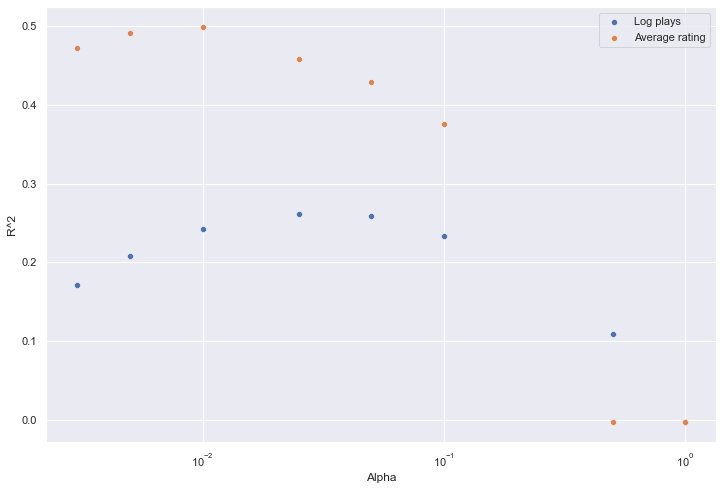

In [575]:
plt.figure(figsize = (12,8))
sns.scatterplot(x= alphas, y=lp_test_r2s, label = 'Log plays')
sns.scatterplot(x= alphas, y=ar_test_r2s, label = 'Average rating')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()

In [580]:
lp_results = lr_cv(train_df, x_cols, 'log_plays', Lasso(alpha=.025), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)
lp_results = lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=.01), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)

Objective: log_plays
Features:  
Mean train r2: 0.367
Mean test r2:  0.261

Objective: avg_rating
Features:  
Mean train r2: 0.543
Mean test r2:  0.499



***Best alpha values are .01 for average rating and .025 for log plays, but will just use LassoCV going forward. Going to use alphas list though because it has trouble converging with its default range***

### Just Regularization

In [1229]:
lr_cv(train_df, x_cols, 'log_plays', LassoCV(),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', LassoCV(), 
      scale=True,show_results=True,xcols_name='gp+t+c');

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.267
Mean test r2:  0.240

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.468
Mean test r2:  0.449



In [1230]:
lr_cv(train_df, x_cols, 'log_plays', RidgeCV(),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', RidgeCV(), 
      scale=True,show_results=True,xcols_name='gp+t+c');

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.270
Mean test r2:  0.239

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.470
Mean test r2:  0.447



**Just retularization doesnt really help as much as polynomial features + regularization**

## Looking at residuals and pair plots

R^2: 0.205
MAE: 1.183


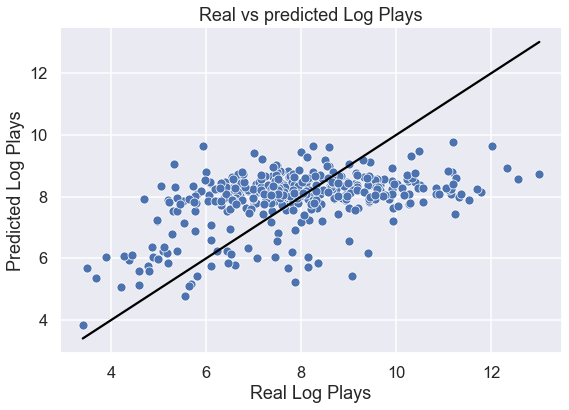

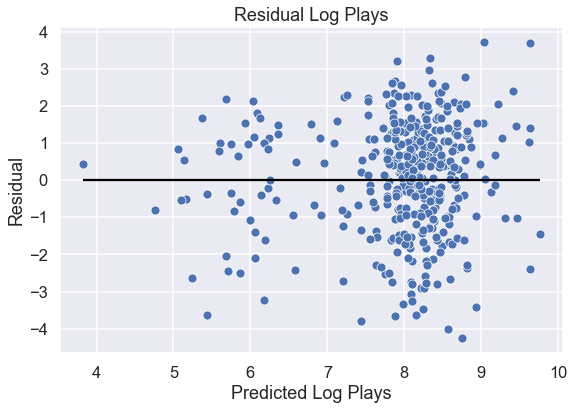

In [1231]:
fit_plot_train(train_df, x_cols, 'log_plays', 'Log Plays', LassoCV(alphas = alphas, max_iter= 10000),
               transformer=PolynomialFeatures(include_bias = False,interaction_only=False),
               scale=True, show_graphs = True)


Some weird bimodality going on here, not sure why it predicts so many things will be around 8 log_plays

R^2: 0.459
MAE: 0.346


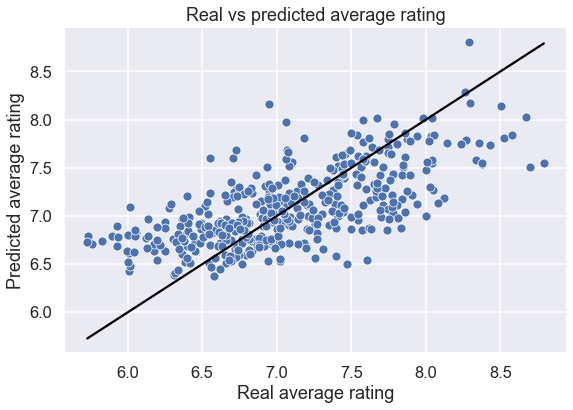

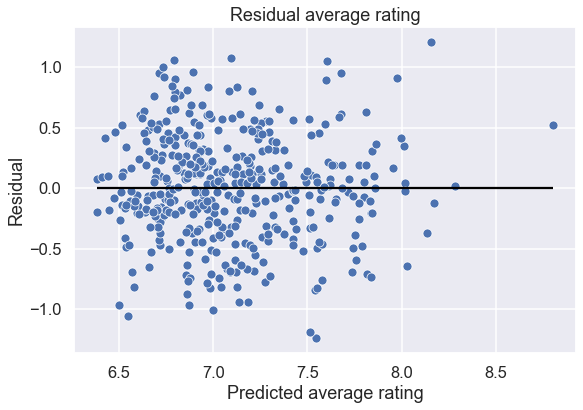

In [1232]:
fit_plot_train(train_df, x_cols, 'avg_rating', 'average rating', LassoCV(alphas=alphas),
               transformer=PolynomialFeatures(include_bias = False,interaction_only=False),
               scale=True, show_graphs = True)

Average rating real vs predicted and residual graphs look better. Top at least looks likes its centered around a line, except for low real values (easier to predict when game is good?), and bottom doesnt have too much variance between predicted values.

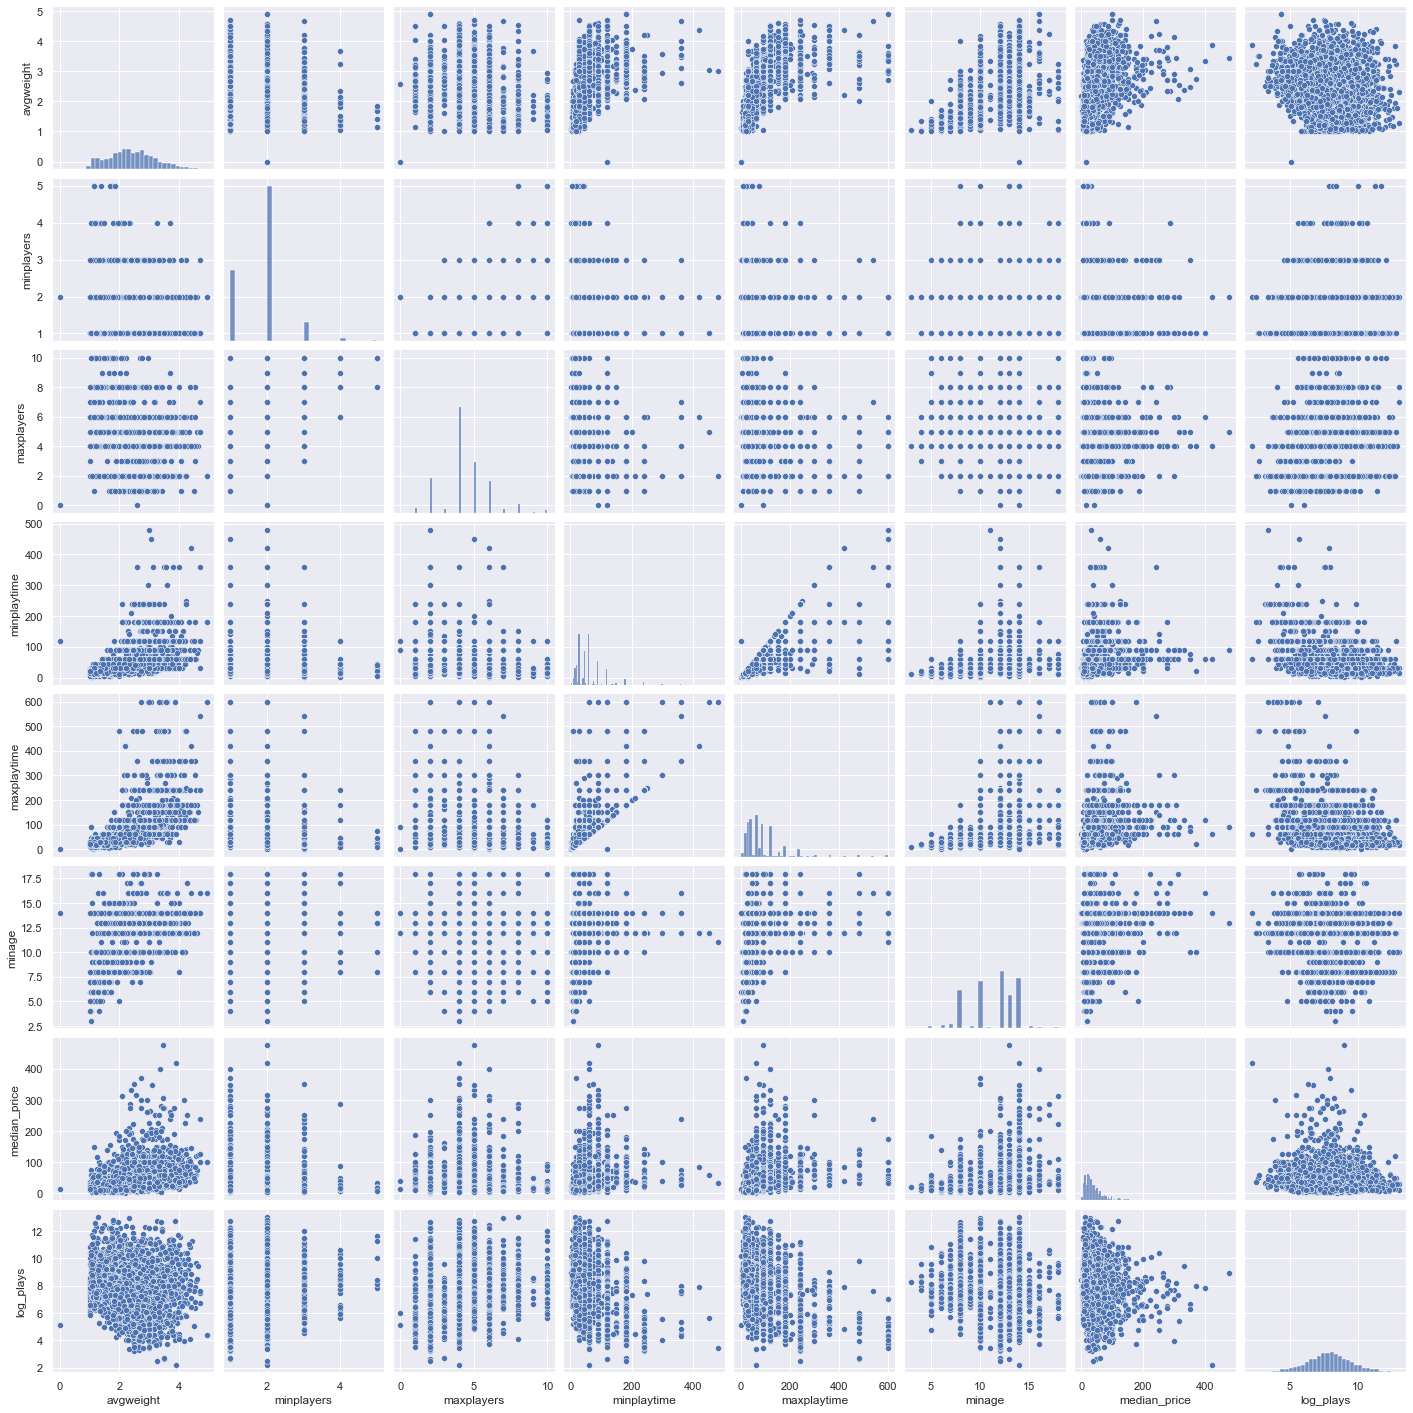

In [586]:
sns.pairplot(df[game_properties + ['log_plays']])

**Hard to see any functional dependence of log_plays on anything

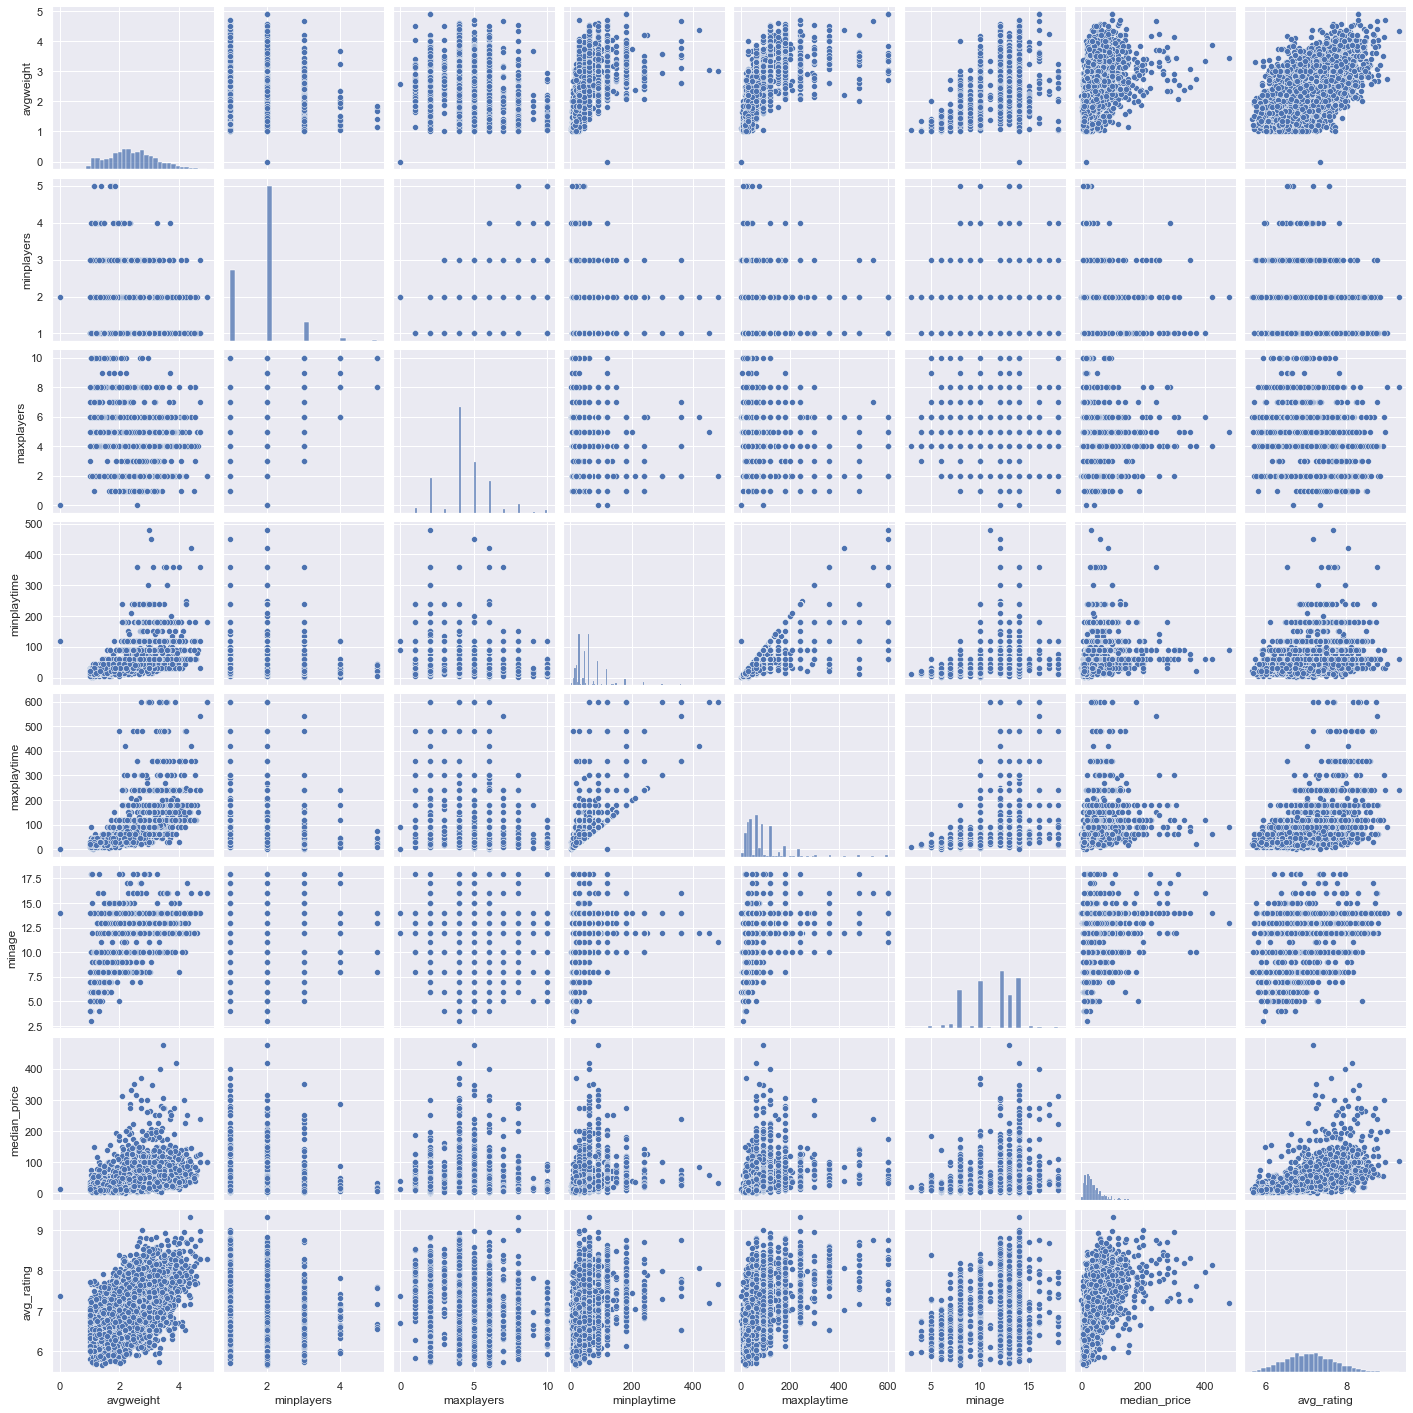

In [587]:
sns.pairplot(df[game_properties + ['avg_rating']])

**Looks like minplaytime and maxplaytime and median_price might  have square root or log dependence for avg_rating**

## Changing around features and misc adjustments

### Interaction_only testing

In [743]:
lr_cv(train_df, x_cols, 'avg_rating', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=True),scale=True,
                       show_results=True)
lr_cv(train_df, x_cols, 'avg_rating', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True);

lr_cv(train_df, x_cols, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=True),scale=True,
                       show_results=True)
lr_cv(train_df, x_cols, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True);

Objective: avg_rating
Features:  
Mean train r2: 0.507
Mean test r2:  0.448

Objective: avg_rating
Features:  
Mean train r2: 0.527
Mean test r2:  0.480

Objective: log_plays
Features:  
Mean train r2: 0.326
Mean test r2:  0.248

Objective: log_plays
Features:  
Mean train r2: 0.358
Mean test r2:  0.261



Having interaction_only = False seems slightly better

### Squre root of numerical colums

In [725]:
lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=.01), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)
lr_cv(train_df, x_cols_sqrt, 'avg_rating', Lasso(alpha=.01), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True);

Objective: avg_rating
Features:  
Mean train r2: 0.542
Mean test r2:  0.488

Objective: avg_rating
Features:  
Mean train r2: 0.542
Mean test r2:  0.488



In [724]:
lp_results = lr_cv(train_df, x_cols, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)
lp_results = lr_cv(train_df, x_cols_sqrt, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)

Objective: log_plays
Features:  
Mean train r2: 0.369
Mean test r2:  0.276

Objective: log_plays
Features:  
Mean train r2: 0.369
Mean test r2:  0.276



Taking the square root of some of the columns doesnt really do anything - just going to call it for avg_rating, going to try a bit more for log_plays

### Using fewer columns

In [761]:
price_only = ['median_price']+type_cols+selected_categories
weight_only = ['avgweight']+type_cols+selected_categories
reduced = ['avgweight', 'minplayers','minplaytime',  'minage', 'median_price']+type_cols+selected_categories
lp_results = lr_cv(train_df, reduced, 'log_plays', LinearRegression(), show_results=True)
lp_results = lr_cv(train_df, reduced, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)

Objective: log_plays
Features:  
Mean train r2: 0.274
Mean test r2:  0.234

Objective: log_plays
Features:  
Mean train r2: 0.336
Mean test r2:  0.251



cycled through these, not really any improvement

## Final modeling/viz

In [970]:
xc_nicenames = ['Complexity', 'Minimum Players', 'Maximum Players', 'Miniumum Playtime', 'Maximum Playtime', 'Minimum Age',
                'Price','Customizable', 'Family', 'Strategy', 'Thematic'] + selected_categories
xc_nicenames = ['* '+name for name in xc_nicenames]

In [1115]:
def coef_df(model):
    """
    Takes in model (sklearn pipeline object) and returns DataFrame with information on the fit coefficients,
    sorted by the absolute value of the coefficient
    
    """
    features = model.steps[0][-1].get_feature_names(xc_nicenames)
    coefs = model.steps[-1][-1].coef_
    df = pd.DataFrame(list(zip(features,coefs)),columns =['feature', 'coef'])
    df['feature'] = df['feature'].apply(lambda s: s[2:])
    df['Sign'] = df['coef'].apply(lambda c: 'Positive' if c>0 else 'Negative')
    df['abs_coef'] = np.abs(df['coef'])
    df.sort_values('abs_coef', ascending=False, inplace=True)
    return df

def plot_coef_df(coef_df, num_features, title):
    """
    Plots a bar graph of the top num_features (by absolute value) from a dataframe made by coef_df
    """
    sns.set(font_scale=2)
    plt.figure(figsize=(18,12))
    sns.barplot(x='abs_coef', y='feature',data=coef_df.head(num_features),
                hue = 'Sign', dodge=False, hue_order = ['Negative', 'Positive'])
    plt.ylabel('')
    plt.xlabel('Scaled fit coefficient')
    plt.title('Most predictive features for ' + title, fontsize = 32)

In [1233]:
def fit_plots(model, X_test, y_test, objective_name):
    """
    Takes in model (sklearn pipeline) and plots real vs predicted values and residual graph
    """
    y_pred = model.predict(X_test)
    
    
    plt.figure(figsize=(18,12))
    
    sns.scatterplot(x=y_pred, y=y_test)
    plt.ylabel('Real '+objective_name)
    plt.xlabel('Predicted '+objective_name)
    plt.title('Real vs predicted ' + objective_name)
    yx_line = np.linspace(np.min(y_test),np.max(y_test),1000)
    plt.plot(yx_line,yx_line,color='black', ls = '--')
    plt.show()
    
    plt.figure(figsize=(18,12))
    res = (np.array(y_pred)-np.array(y_test))
    sns.scatterplot(x=y_pred, y=res)
    plt.xlabel('Predicted '+objective_name)
    plt.ylabel('Residual')
    plt.title('Residual ' + objective_name)
    plt.hlines(0,np.min(y_pred),np.max(y_pred),colors='black', ls='--')
    plt.show()

### Final Average Rating model

In [1049]:

X_train = train_df[x_cols].copy()
X_test = test_df[x_cols].copy()
y_train_ar = train_df['avg_rating'].copy()
y_test_ar  =  test_df['avg_rating'].copy()


rating_model = make_pipeline(PolynomialFeatures(include_bias=False,interaction_only=False), StandardScaler(),
                                 LassoCV(alphas=alphas,max_iter=10000))


rating_model.fit(X_train, y_train_ar)
print('Training R2',rating_model.score(X_train, y_train_ar))
print('Test R2',rating_model.score(X_test,  y_test_ar))
print('Test MAE', mean_absolute_error(y_test_ar,rating_model.predict(X_test)))

Training R2 0.5191296612181358
Test R2 0.49101978542073965
Test MAE 0.3430360518831899


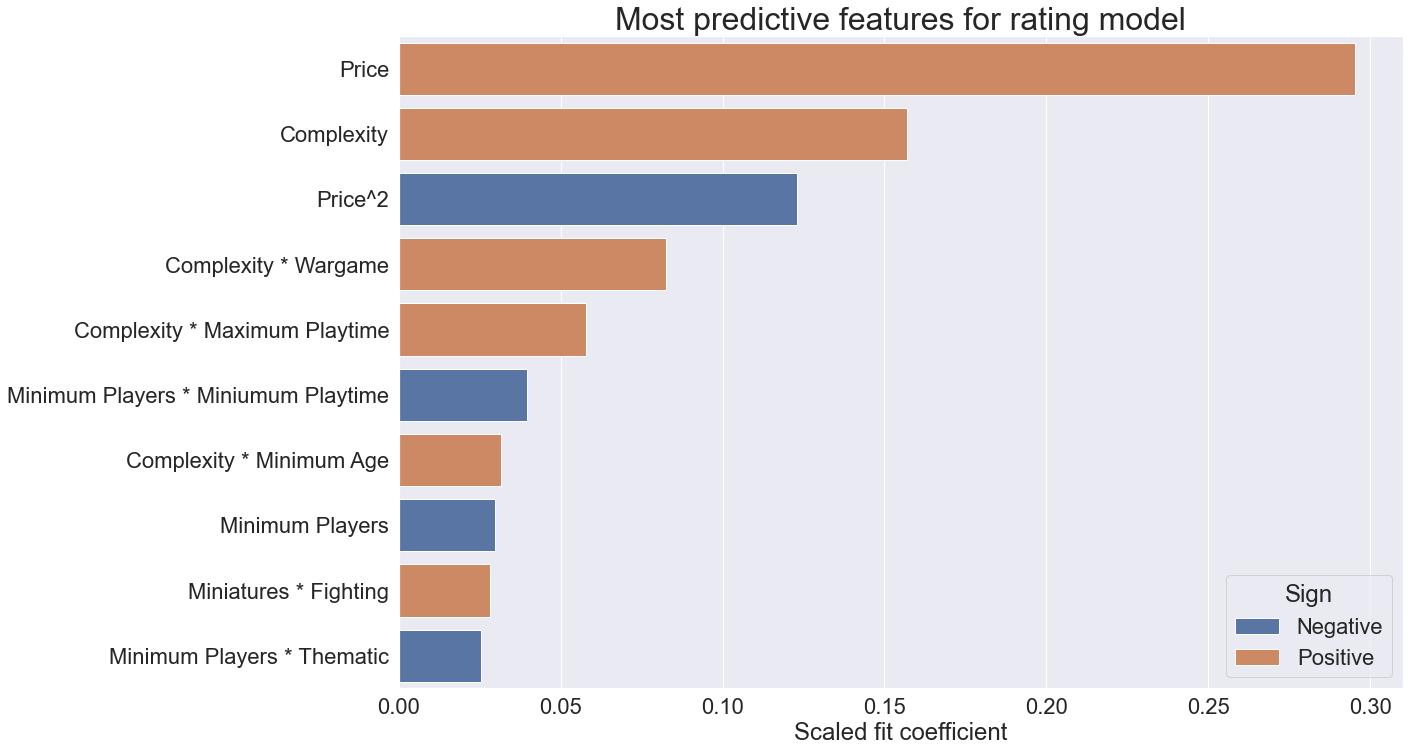

In [1116]:
rating_cdf = coef_df(rating_model)
plot_coef_df(rating_cdf,10, 'rating model')

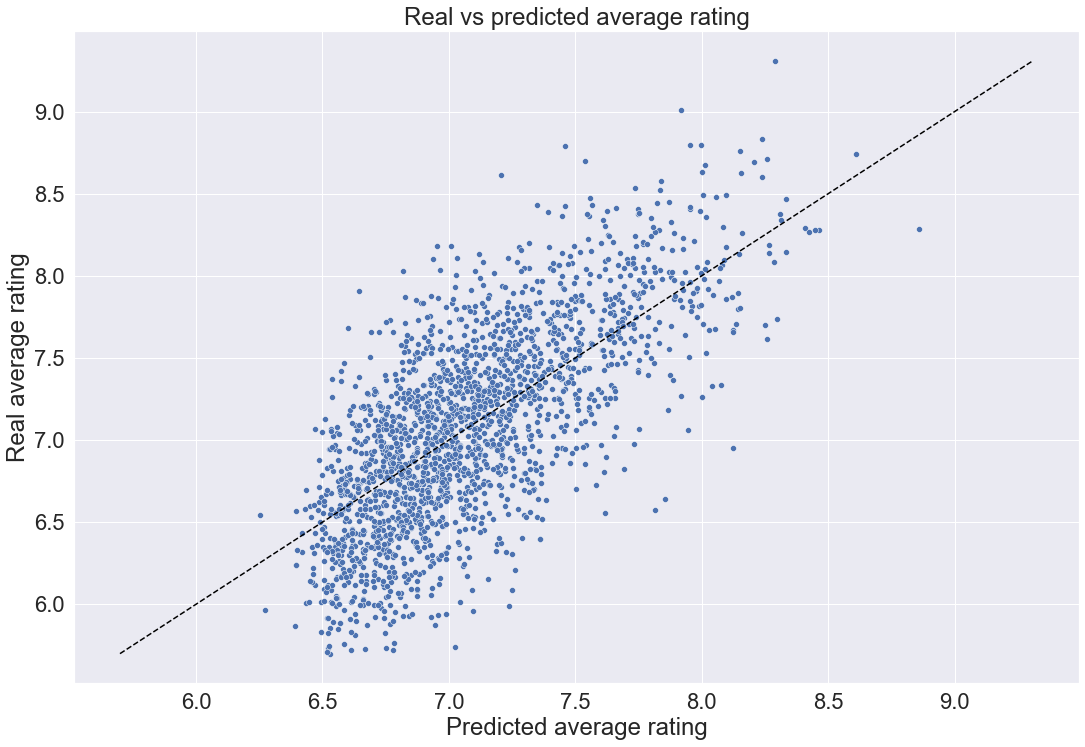

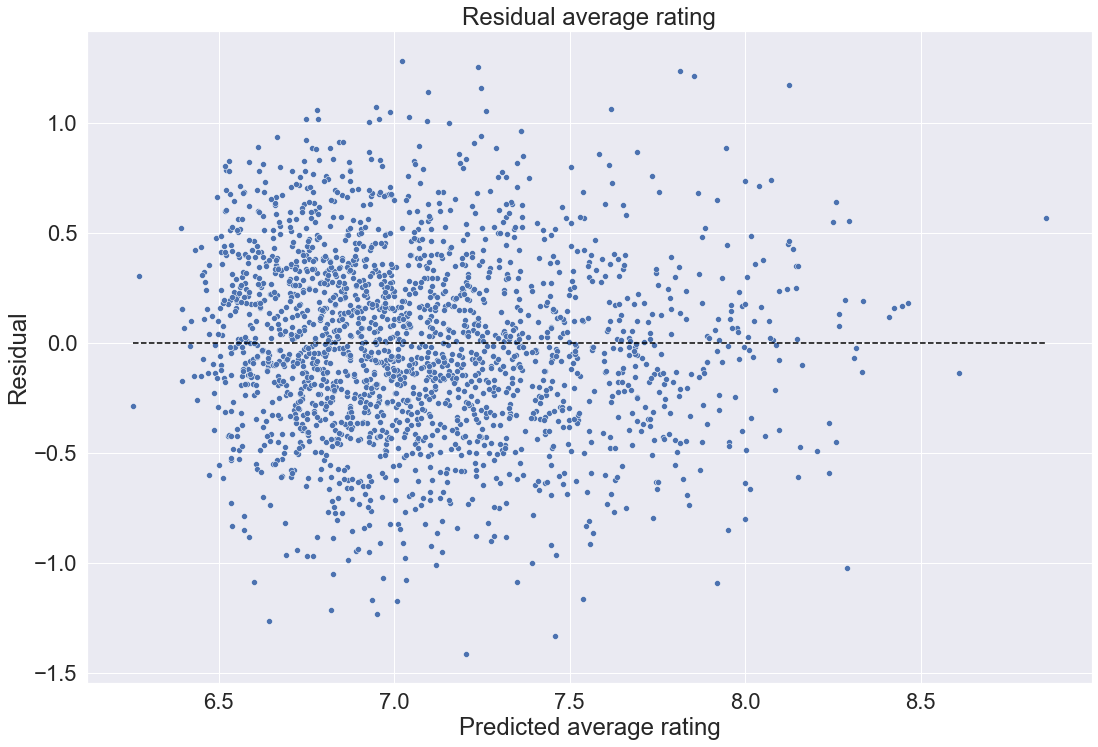

In [1104]:
fit_plots(rating_model, X_train, y_train_ar, 'average rating')

In [1112]:
print((rating_cdf['abs_coef'] != 0).sum())
print(len(rating_cdf))

74
464


### Final Log Plays Model

In [1129]:
X_train = train_df[x_cols].copy()
X_test = test_df[x_cols].copy()
y_train_lp = train_df['log_plays'].copy()
y_test_lp  =  test_df['log_plays'].copy()


logplays_model = make_pipeline(PolynomialFeatures(include_bias=False,interaction_only=False), StandardScaler(),
                                 LassoCV(alphas=alphas,max_iter=10000))

logplays_model.fit(X_train, y_train_lp)
print('Training R2',logplays_model.score(X_train, y_train_lp))
print('Test R2',logplays_model.score(X_test,  y_test_lp))
print('Test MAE',mean_absolute_error(y_test_lp, logplays_model.predict(X_test)))

Training R2 0.3502212797903277
Test R2 0.26965373463838604
Test MAE 1.1320233098638997


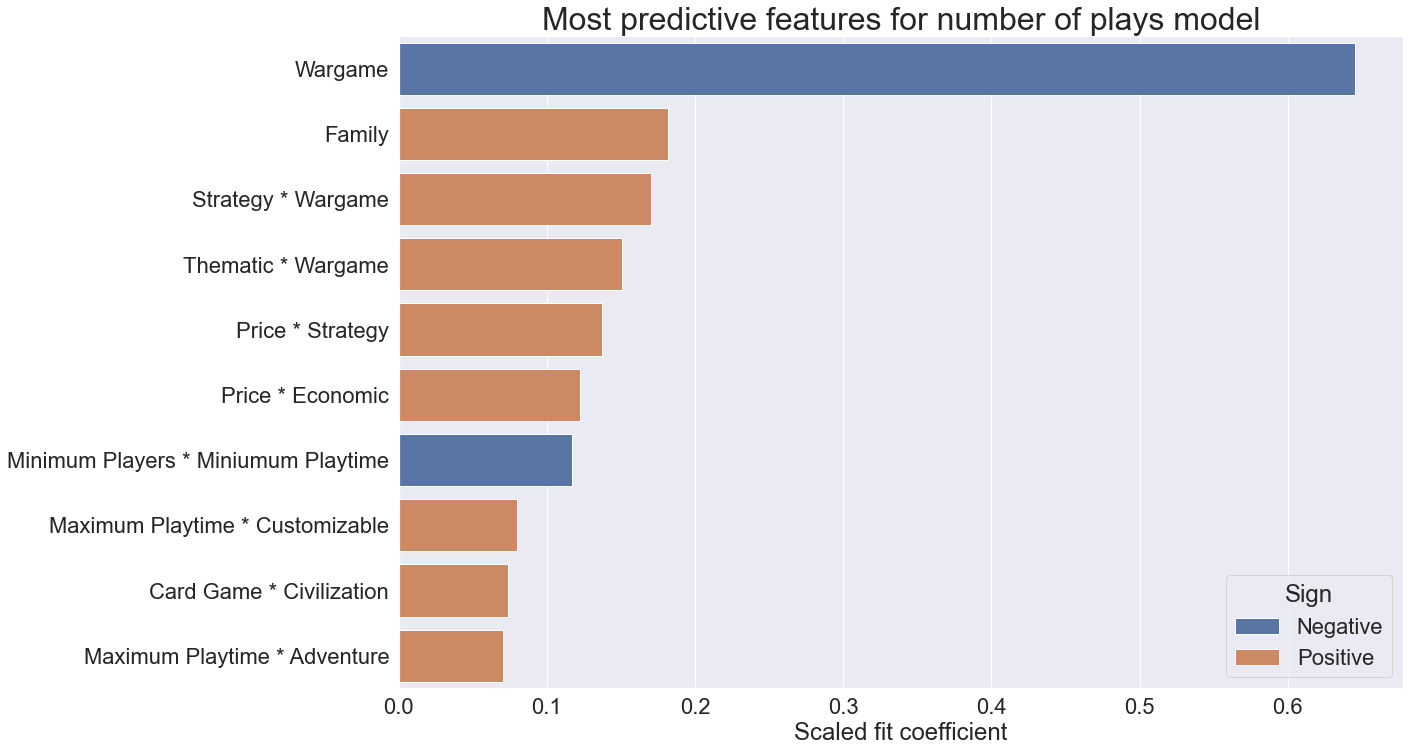

In [1132]:
logplays_cdf = coef_df(logplays_model)
plot_coef_df(logplays_cdf,10, 'number of plays model')

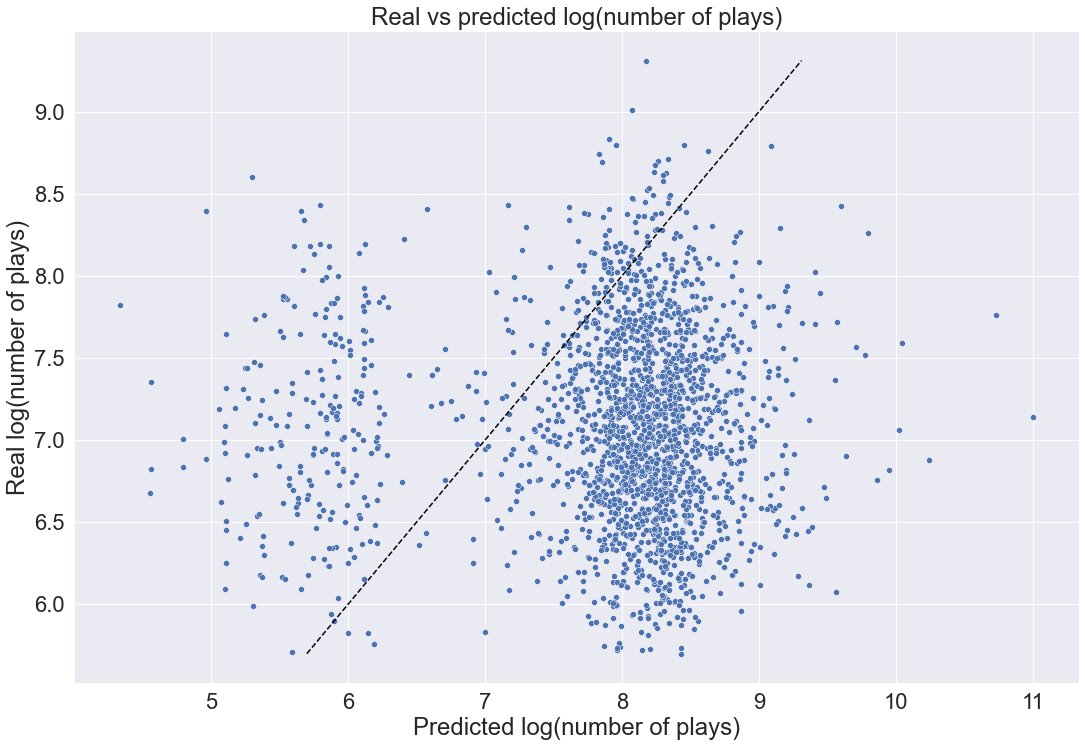

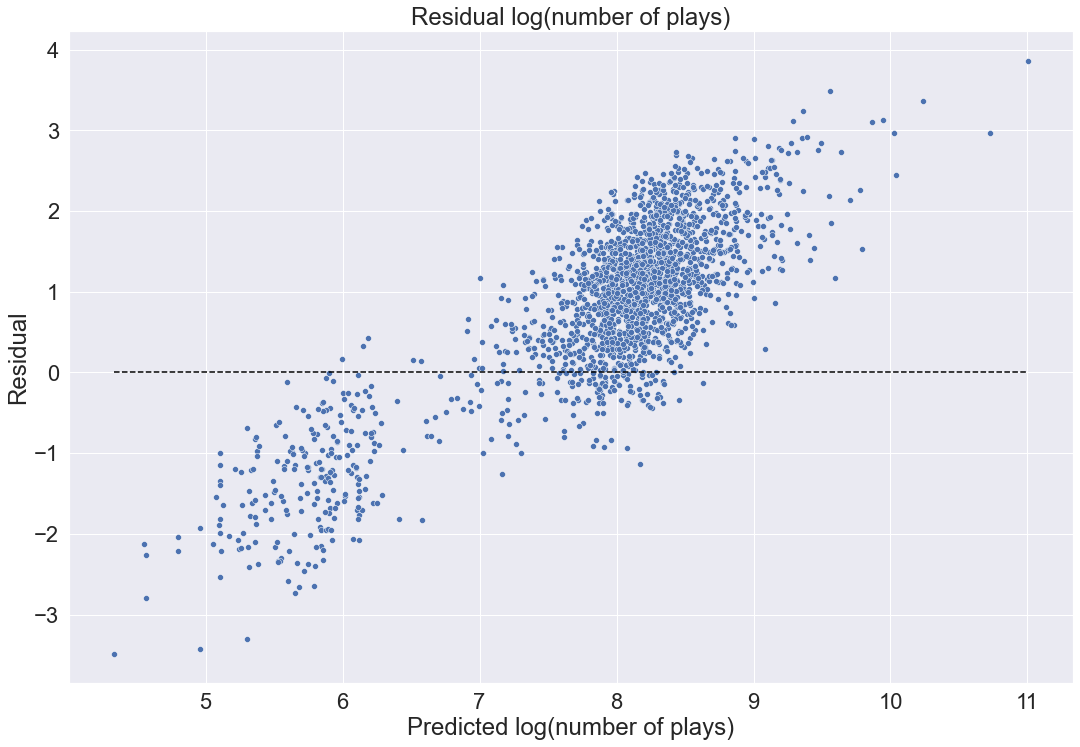

In [1130]:
fit_plots(logplays_model, X_train, y_train_ar, 'log(number of plays)')

## For fun - randomly generating games

In [1177]:
def make_random_game():
    from random import uniform, randrange,randint
    game = []
    game.append(round(uniform(1,5),2)) #weight
    game.append(randint(1,10))
    game.append(randint(game[1],10))
    game.append(randrange(10,120,10))
    game.append(randrange(game[3],480,10))
    game.append(randint(1,21))
    game.append(randint(10,500))
    categories = np.random.randint(2, size = 22)
    game+= list(categories)
    return game

def rgame_info(game, name):
    print('Name:',name)
    for num,category in zip(game[:7],xc_nicenames[:7]):
        print(category,':',num)
    print('Categories:')
    for num,category in zip(game[7:],xc_nicenames[7:]):
        
        if num ==1: print(category)
    print('Predicted rating:', round(rating_model.predict([game])[0],1))
          

In [1178]:
SG=make_random_game()
rgame_info(SG, 'Savage Goth from Planet X')


Name: Savage Goth from Planet X
* Complexity : 2.98
* Minimum Players : 4
* Maximum Players : 5
* Miniumum Playtime : 110
* Maximum Playtime : 300
* Minimum Age : 15
* Price : 116
Categories:
* Customizable
* Strategy
* Print & Play
* Wargame
* Abstract Strategy
* Science Fiction
* Fantasy
* Civilization
* Bluffing
* Animals
Predicted rating: 8.0


In [1087]:
ISU=make_random_game()
rgame_info(ISU, 'Interstellar Sandwich Unleashed')

Name: Interstellar Sandwich Unleashed
avgweight : 1.33
minplayers : 3
maxplayers : 6
minplaytime : 100
maxplaytime : 460
minage : 7
median_price : 87
Categories:
customizable
family
thematic
Print & Play
Science Fiction
Fantasy
Civilization
Adventure
City Building
Exploration
Bluffing
Fighting
Predicted rating:  [6.41906706]


In [1202]:
OHA = make_random_game()
rgame_info(OHA, 'Occult Hamster Apocalypse')

Name: Occult Hamster Apocalypse
* Complexity : 4.11
* Minimum Players : 2
* Maximum Players : 7
* Miniumum Playtime : 10
* Maximum Playtime : 380
* Minimum Age : 14
* Price : 73
Categories:
* Strategy
* Thematic
* Wargame
* Abstract Strategy
* Science Fiction
* Fantasy
* Deduction
* Horror
* Adventure
* Party Game
* City Building
* Bluffing
* Fighting
Predicted rating: 9.5
